In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pathlib
import os, collections

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_rows', 9999)
pd.set_option('max_columns', 9999)

os.listdir('../input')

['weather_test.csv',
 'weather_train.csv',
 '.DS_Store',
 'test.csv',
 'prep_test_20191125.pkl',
 'train.csv',
 'building_metadata.csv',
 'prep_train_20191125.pkl',
 'sample_submission.csv']

---
## Data Loading

In [2]:
def reduce_mem_usage(df):
    for col in df.columns:
        if df[col].dtype == int:
            m = df[col].max()
            if m > np.iinfo(np.uint32).max:
                df[col] = df[col].astype(np.uint64)
            elif m > np.iinfo(np.uint16).max:
                df[col] = df[col].astype(np.uint32)
            elif m > np.iinfo(np.uint8).max:
                df[col] = df[col].astype(np.uint16)
            elif m < np.iinfo(np.uint8).max:
                df[col] = df[col].astype(np.uint8)
                
        elif df[col].dtype == float:
            m = df[col].max()
            if m > np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float64)
            elif m > np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float32)
        
    return df

In [3]:
data_dir = pathlib.Path('../input/')

df_building = pd.read_csv(data_dir.joinpath('building_metadata.csv'))
df_weather_train = pd.read_csv(data_dir.joinpath('weather_train.csv'))
df_weather_test = pd.read_csv(data_dir.joinpath('weather_test.csv'))
df_train = pd.read_csv(data_dir.joinpath('train.csv'))
df_test = pd.read_csv(data_dir.joinpath('test.csv'))

In [4]:
df_building = reduce_mem_usage(df_building)
df_weather_train = reduce_mem_usage(df_weather_train)
df_weather_test = reduce_mem_usage(df_weather_test)
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

In [5]:
print('Train Shape:', df_train.shape)
print('Test Shape:', df_test.shape)
print('Weather Train Shape:', df_weather_train.shape)
print('Weather Test Shape:', df_weather_test.shape)
print('Building Metadata Shape:', df_building.shape)

Train Shape: (20216100, 4)
Test Shape: (41697600, 4)
Weather Train Shape: (139773, 9)
Weather Test Shape: (277243, 9)
Building Metadata Shape: (1449, 6)


In [6]:
# Reduce Amount of Train & Test Data (for memory)

# df_train = df_train.sample(frac=0.05, random_state=0).reset_index(drop=True)
# df_test = df_test.sample(frac=0.05, random_state=0).reset_index(drop=True)

In [7]:
display(df_train.head())
df_train.dtypes

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


building_id       uint16
meter              uint8
timestamp         object
meter_reading    float32
dtype: object

In [8]:
display(df_test.head())
df_test.dtypes

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


row_id         uint32
building_id    uint16
meter           uint8
timestamp      object
dtype: object

In [9]:
display(df_weather_train.head())
df_weather_train.dtypes

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


site_id                 uint8
timestamp              object
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

In [10]:
display(df_weather_test.head())
df_weather_test.dtypes

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


site_id                 uint8
timestamp              object
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

In [11]:
display(df_building.head())
df_building.dtypes

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


site_id          uint8
building_id     uint16
primary_use     object
square_feet     uint32
year_built     float64
floor_count    float64
dtype: object

---
## Concatenate Dataset

train.csv|test.csv & building_metadata.csv
 →Key: 'building_id'
 
 
 train.csv|test.csv & weather data
 →Key: 'site_id' & 'timestamp'

In [12]:
df_train = df_train.merge(df_building, on='building_id', how='left')
df_train = df_train.merge(df_weather_train, on=['site_id', 'timestamp'], how='left')

df_test = df_test.merge(df_building, on='building_id', how='left')
df_test = df_test.merge(df_weather_test, on=['site_id', 'timestamp'], how='left')

del df_building, df_weather_train, df_weather_test

In [13]:
print('Train Shape:', df_train.shape)
df_train.head()

Train Shape: (20216100, 16)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [14]:
print('Test Shape:', df_test.shape)
df_test.head()

Test Shape: (41697600, 16)


,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6


---
### Target Feature - meter_reading

In [17]:
target = 'meter_reading'

df_train[target].isnull().sum()

0

In [18]:
df_train[target].describe()

count    2.021610e+07
mean     2.117122e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [19]:
len(df_train[df_train[target] == 0]) / len(df_train) * 100

# >9% of the total is 0

9.269720668180312

In [22]:
build_0 = df_train[df_train['building_id'] == 0]
print(build_0.shape)
build_0.head()

# 2016 is a leap year
# Therefore, line 8784 = 24 Hours * 366 Days

(8784, 16)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2301,0,0,2016-01-01 01:00:00,0.0,0,Education,7432,2008.0,NaN,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
4594,0,0,2016-01-01 02:00:00,0.0,0,Education,7432,2008.0,NaN,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
6893,0,0,2016-01-01 03:00:00,0.0,0,Education,7432,2008.0,NaN,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
9189,0,0,2016-01-01 04:00:00,0.0,0,Education,7432,2008.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


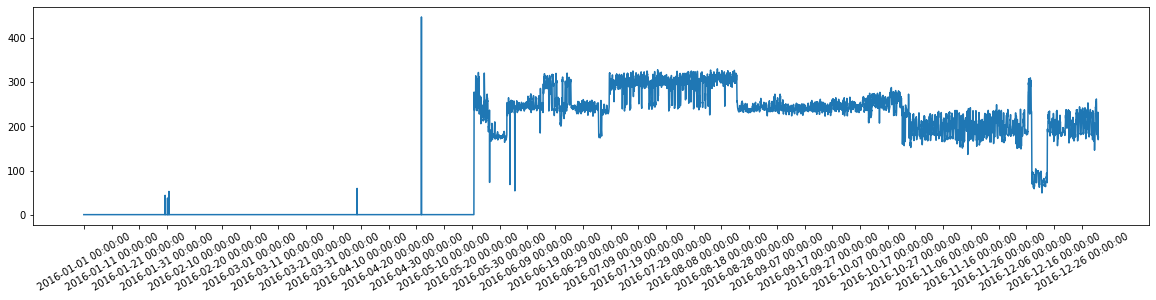

In [23]:
fig = plt.figure(figsize=(20, 4), facecolor='w')
plt.plot(build_0['timestamp'], build_0[target])
plt.xticks(np.arange(0, len(build_0), 240), rotation=30)
plt.show()

# Does outliner exist around 2016-05-01?

In [15]:
def plot_meter(building_id):
    temp = df_train[df_train['building_id'] == building_id]
    use = temp['primary_use'].values[0]
    meter_0 = temp[temp['meter'] == 0][['timestamp', 'meter_reading']].reset_index(drop=True)
    meter_0['meter_reading_0'] = meter_0.pop('meter_reading')
    meter_1 = temp[temp['meter'] == 1][['timestamp', 'meter_reading']].reset_index(drop=True)
    meter_1['meter_reading_1'] = meter_1.pop('meter_reading')
    meter_2 = temp[temp['meter'] == 2][['timestamp', 'meter_reading']].reset_index(drop=True)
    meter_2['meter_reading_2'] = meter_2.pop('meter_reading')
    meter_3 = temp[temp['meter'] == 3][['timestamp', 'meter_reading']].reset_index(drop=True)
    meter_3['meter_reading_3'] = meter_3.pop('meter_reading')

    meter = meter_0.merge(meter_1, on='timestamp', how='outer')
    meter = meter.merge(meter_2, on='timestamp', how='outer')
    meter = meter.merge(meter_3, on='timestamp', how='outer')
    meter.fillna(0, inplace=True)
    del meter_0, meter_1, meter_2, meter_3
    
    color_dict = {'electricity': 'y', 'chill water': 'b', 'steam': 'g', 'hotwater': 'r'}

    for i, (label, c) in enumerate(color_dict.items()):
        # Do not create the graph using All 0 Values (meter)
        if meter['meter_reading_{}'.format(i)].sum() == 0:
            continue
        fig = plt.figure(figsize=(20, 4), facecolor='w')
        plt.plot(meter['timestamp'], meter['meter_reading_{}'.format(i)], label=label, color=c)
        plt.xticks(np.arange(0, len(meter), 240), rotation=30)
        plt.legend()
        plt.title('Building_Id: {}  Primary_use: {}'.format(building_id, use))
        plt.show()

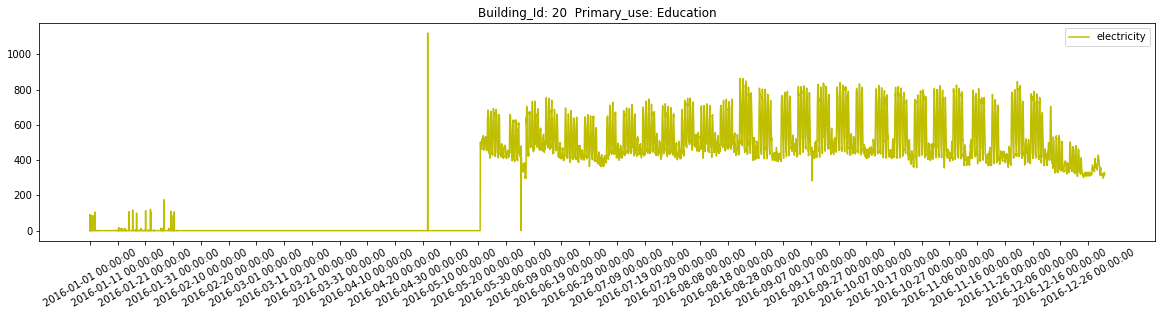

In [26]:
plot_meter(building_id=20)

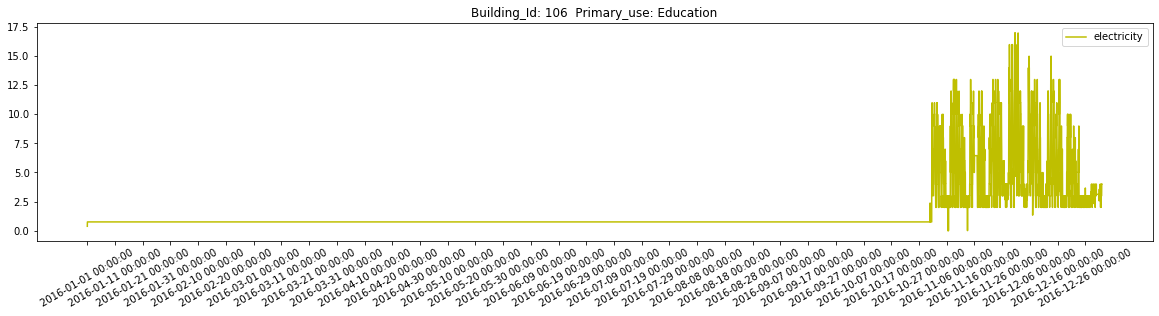

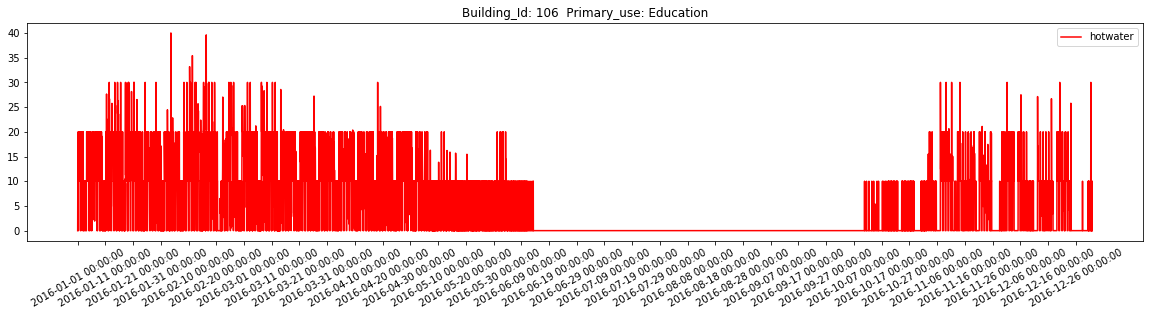

In [27]:
plot_meter(building_id=106)

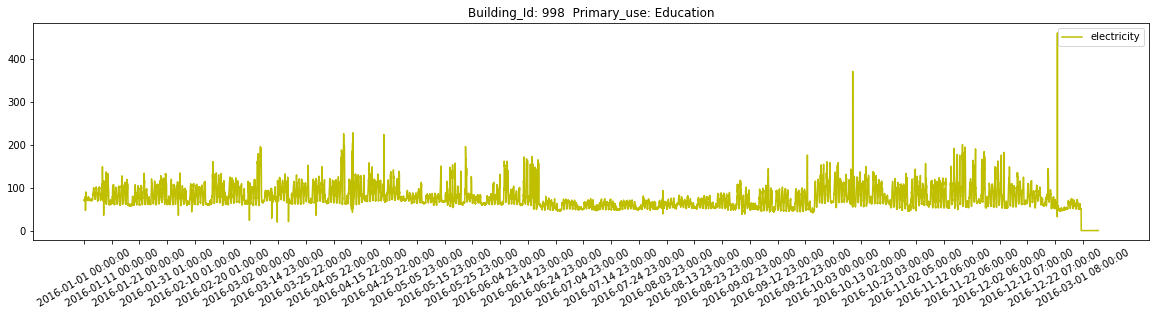

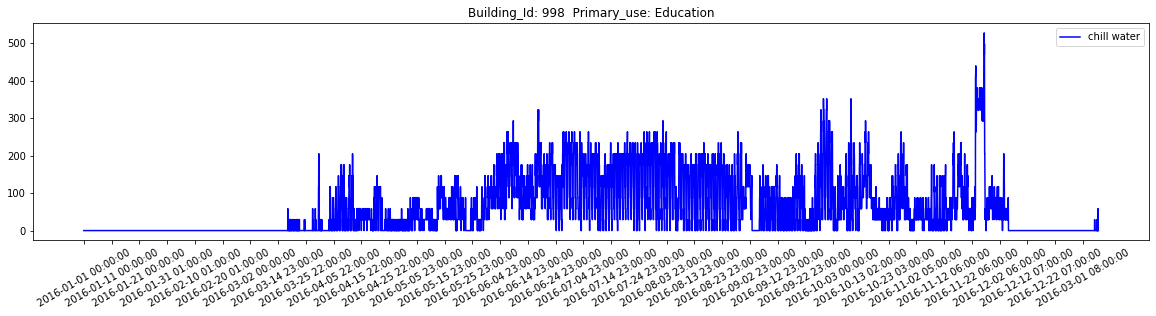

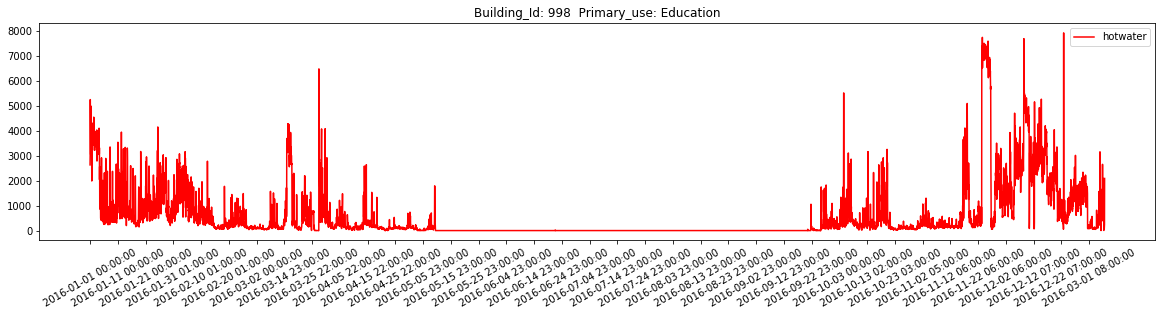

In [28]:
plot_meter(building_id=998)

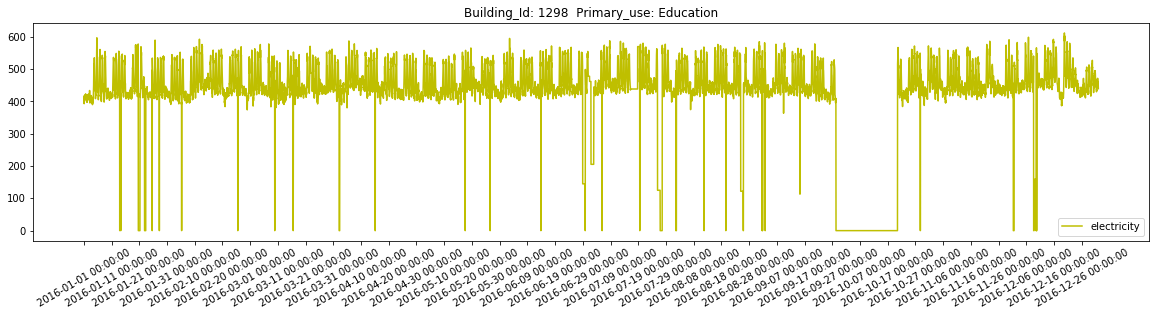

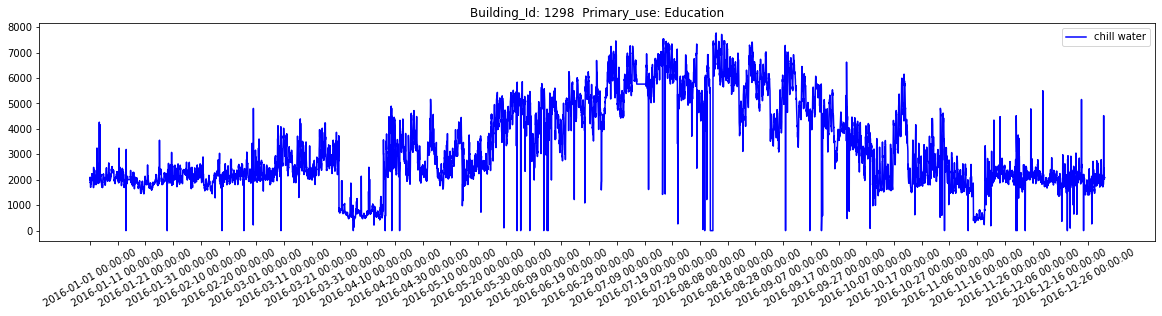

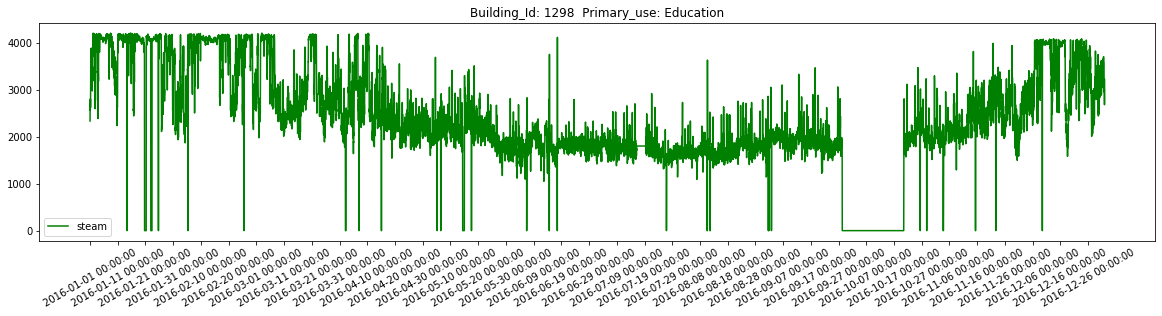

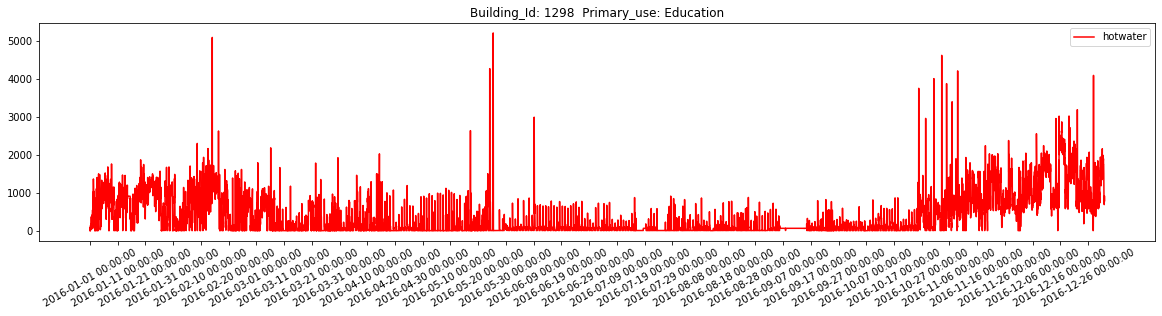

In [29]:
plot_meter(building_id=1298)

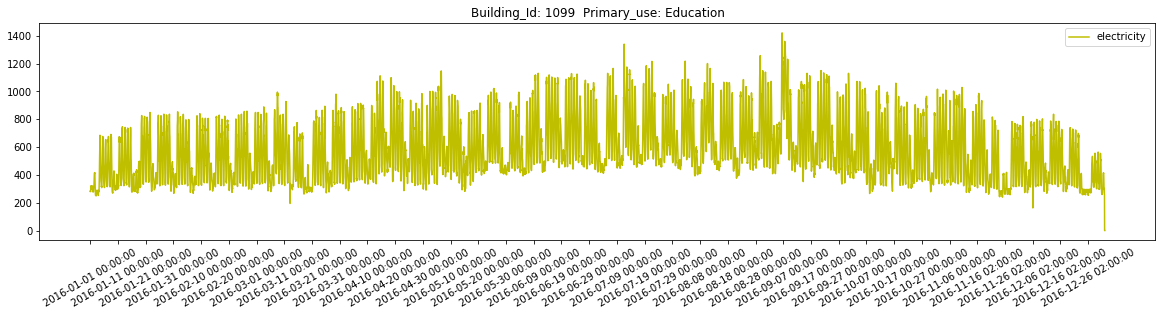

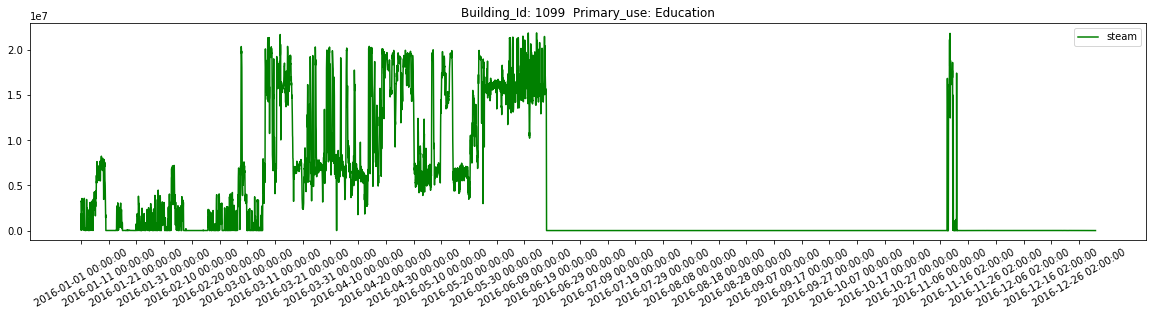

In [16]:
plot_meter(building_id=1099)

In [60]:
target_per_building = df_train.groupby(['building_id', 'meter'])['meter_reading'].sum().reset_index()
target_per_building.head()

,building_id,meter,meter_reading
0,0,0,1.286460e+06
1,1,0,6.576176e+05
2,2,0,1.278194e+05
3,3,0,2.069071e+06
4,4,0,8.578074e+06


In [46]:
df_building = pd.read_csv(data_dir.joinpath('building_metadata.csv'))

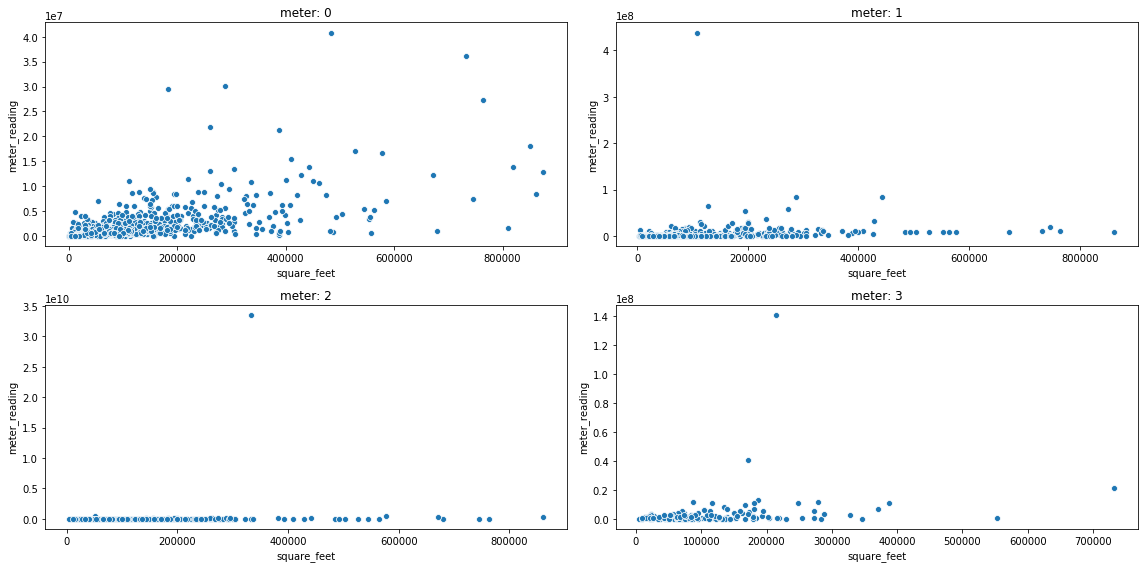

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
for i, ax in enumerate(axes.ravel()):
    temp = pd.merge(df_building, target_per_building[target_per_building['meter'] == i], on='building_id')
    sns.scatterplot(x='square_feet', y='meter_reading', data=temp, ax=ax)
    ax.set_title('meter: {}'.format(i))
    
plt.tight_layout()
plt.show()

In [57]:
df_train["timestamp"] = pd.to_datetime(df_train["timestamp"])
df_test["timestamp"] = pd.to_datetime(df_test["timestamp"])

df_train["month"] = df_train["timestamp"].dt.month.astype(np.uint8)
df_train["day"] = df_train["timestamp"].dt.day.astype(np.uint8)
df_train["hour"] = df_train["timestamp"].dt.hour.astype(np.uint8)

df_test["month"] = df_test["timestamp"].dt.month.astype(np.uint8)
df_test["day"] = df_test["timestamp"].dt.day.astype(np.uint8)
df_test["hour"] = df_test["timestamp"].dt.hour.astype(np.uint8)

df_train['weekday'] = df_train['timestamp'].apply(lambda x: x.weekday())
df_test['weekday'] = df_test['timestamp'].apply(lambda x: x.weekday())

In [64]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day,hour,weekday
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,0,4
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,0,4
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,0,4
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,0,4
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,0,4


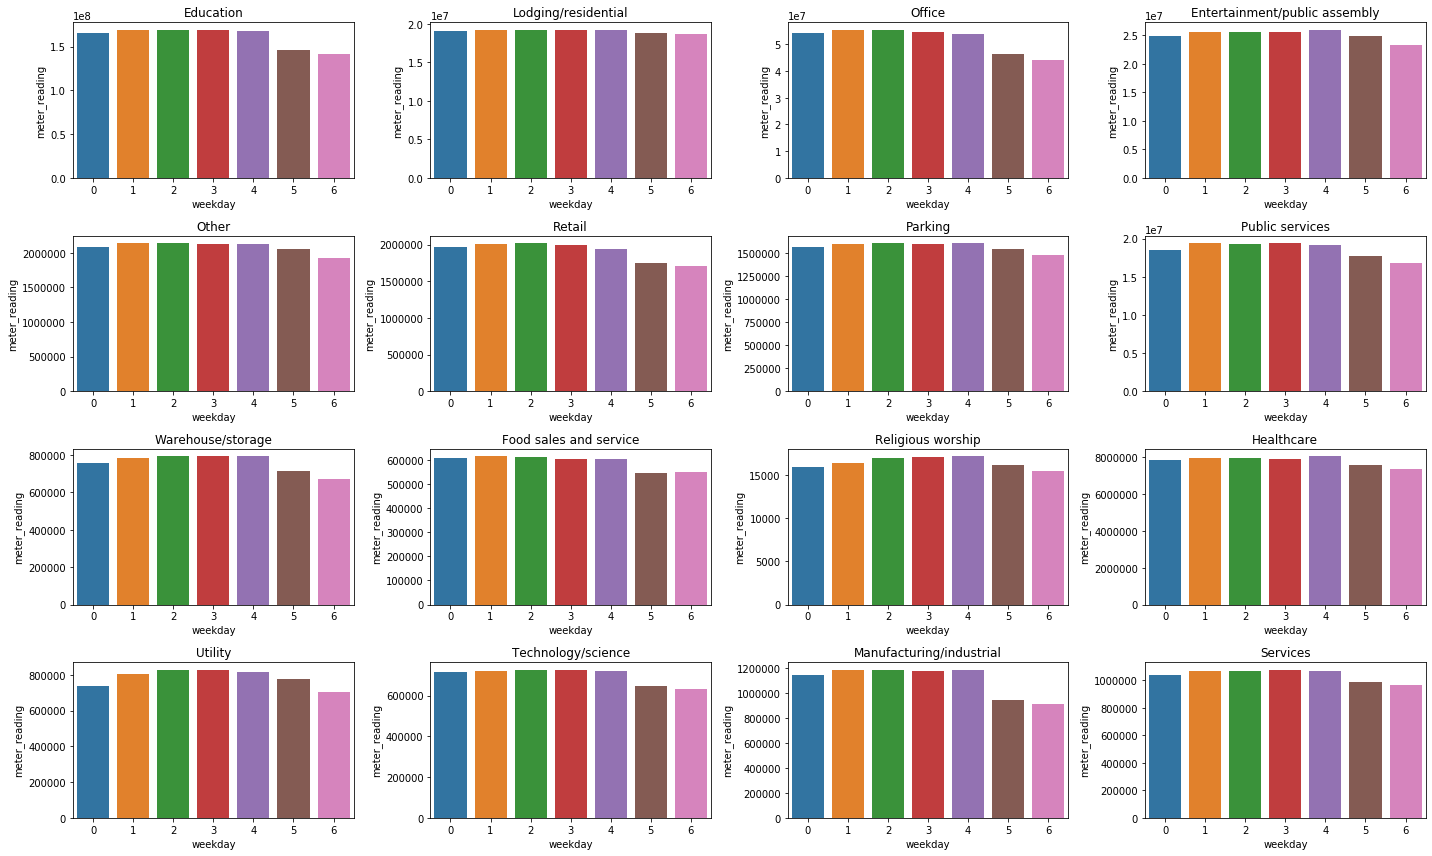

In [83]:
# 曜日ごと
fig, axes = plt.subplots(4, 4, figsize=(20, 12))

for use, ax in zip(df_train['primary_use'].unique(), axes.ravel()):
    temp = df_train.query("primary_use == '{}' & meter == 0".format(use))
    temp = temp.groupby('weekday')['meter_reading'].sum()
    sns.barplot(x='weekday', y='meter_reading', data=pd.DataFrame(temp).reset_index(), ax=ax)
    ax.set_title(use)
plt.tight_layout()
plt.show()

---
### Meter

In [25]:
# Meter frequency distribution by building
_temp = []
for i in range(df_train['building_id'].nunique()):
    meter_list = df_train[df_train['building_id'] == i]['meter'].unique().tolist()
    _temp.append(meter_list)
    
l = []
for i in range(2000):
    try:
        l.extend(_temp[i])
    except:
        pass
    
c = collections.Counter(l)

print('All Building Num:', df_train['building_id'].nunique())
print(c)
# Most common meter is "0"

All Building Num: 1449
Counter({0: 1413, 1: 498, 2: 324, 3: 145})


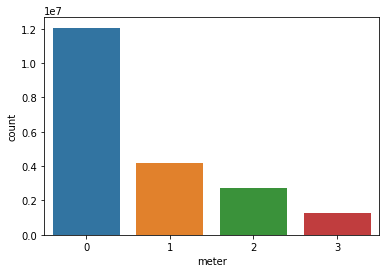

In [26]:
sns.countplot(df_train['meter'])
plt.show()

In [27]:
# mean meter_reading each of meter
# meter 2 (=steam) is the highest value
# Since the target value varies greatly depending on the Meter, it is better to create a model for each Meter.
temp = df_train[df_train['meter_reading'] != 0]
temp.groupby('meter')['meter_reading'].mean()

meter
0      178.679977
1      751.291748
2    15921.589844
3      528.042725
Name: meter_reading, dtype: float32

Coming Soon...

In [84]:
import pytorch

ModuleNotFoundError: No module named 'pytorch'